In [1105]:
import pandas as pd
import numpy as np

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor


import matplotlib.pyplot as plt
import seaborn as sns



from scipy.stats import boxcox



import requests
from io import StringIO  
from bs4 import BeautifulSoup

# Data Gathering and preprocessing

## Housing Price Index (from Bank of Canada)
### available at <a href="https://www.bankofcanada.ca/rates/indicators/capacity-and-inflation-pressures/real-estate-market-definitions/"> here

In [1106]:
housing_index_df = pd.read_csv("../data/INDINF_REAL_ESTATE.csv",skiprows=18)
housing_index_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           173 non-null    object 
 1   INDINF_NHPI_Q  123 non-null    float64
 2   INDINF_AFFORD  172 non-null    float64
dtypes: float64(2), object(1)
memory usage: 4.2+ KB


In [1107]:
housing_index_df['date'] = pd.to_datetime(housing_index_df['date'])


In [1108]:
housing_index_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           173 non-null    datetime64[ns]
 1   INDINF_NHPI_Q  123 non-null    float64       
 2   INDINF_AFFORD  172 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 4.2 KB


In [1109]:
housing_index_df["year"], housing_index_df["month"] = housing_index_df['date'].dt.year, housing_index_df['date'].dt.month

In [1110]:
housing_index_df=housing_index_df.drop(columns=["date"])

In [1111]:
housing_index_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   INDINF_NHPI_Q  123 non-null    float64
 1   INDINF_AFFORD  172 non-null    float64
 2   year           173 non-null    int64  
 3   month          173 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 5.5 KB


In [1112]:
housing_index_df.describe()

,INDINF_NHPI_Q,INDINF_AFFORD,year,month
count,123.000000,172.000000,173.000000,173.000000
mean,2.689431,0.366419,2001.624277,5.508671
std,3.180391,0.070789,12.526850,3.356040
min,-3.100000,0.273000,1980.000000,1.000000
25%,0.900000,0.316750,1991.000000,4.000000
50%,2.100000,0.353000,2002.000000,7.000000
75%,4.350000,0.392750,2012.000000,7.000000
max,11.800000,0.646000,2023.000000,10.000000


In [1113]:
housing_index_df.isnull().sum()

INDINF_NHPI_Q    50
INDINF_AFFORD     1
year              0
month             0
dtype: int64

In [1114]:
housing_index_df

,INDINF_NHPI_Q,INDINF_AFFORD,year,month
0,NaN,0.435,1980,7
1,NaN,0.476,1980,10
2,NaN,0.498,1981,1
3,NaN,0.552,1981,4
4,NaN,0.646,1981,7
...,...,...,...,...
168,6.9,0.507,2022,7
169,4.4,0.498,2022,10
170,1.4,0.497,2023,1
171,-0.5,0.502,2023,4


### Imputed missing values for INDINF_NHPI_Q using KNN imputer for better distribution

In [1115]:
features_for_imputation = ['INDINF_NHPI_Q', 'INDINF_AFFORD', 'year', 'month']

complete_data = housing_index_df.dropna(subset=features_for_imputation)
incomplete_data = housing_index_df[housing_index_df[features_for_imputation].isnull().any(axis=1)]


knn_imputer_nhpi = KNNImputer(n_neighbors=3)
knn_imputer_nhpi.fit(complete_data[features_for_imputation])
imputed_values_nhpi = knn_imputer_nhpi.transform(incomplete_data[features_for_imputation])

housing_index_df.loc[incomplete_data.index, 'INDINF_NHPI_Q'] = imputed_values_nhpi[:, 0]

knn_imputer_afford = KNNImputer(n_neighbors=3)
knn_imputer_afford.fit(complete_data[features_for_imputation])
imputed_values_afford = knn_imputer_afford.transform(incomplete_data[features_for_imputation])

housing_index_df.loc[incomplete_data.index, 'INDINF_AFFORD'] = imputed_values_afford[:, 1]


In [1116]:
housing_index_df

,INDINF_NHPI_Q,INDINF_AFFORD,year,month
0,1.366667,0.435000,1980,7
1,0.800000,0.476000,1980,10
2,1.166667,0.498000,1981,1
3,1.333333,0.552000,1981,4
4,1.366667,0.646000,1981,7
...,...,...,...,...
168,6.900000,0.507000,2022,7
169,4.400000,0.498000,2022,10
170,1.400000,0.497000,2023,1
171,-0.500000,0.502000,2023,4


In [1117]:
housing_index_df.isnull().sum()

INDINF_NHPI_Q    0
INDINF_AFFORD    0
year             0
month            0
dtype: int64

## Interest rates/ Bank rates (from Bank of Canada)
### available at <a href="https://www.bankofcanada.ca/rates/interest-rates/key-interest-rates/?lookupPage=lookup_key_interest.php&startRange=1935-01-01&searchDiff=&searchValue=&searchType=dates&dFrom=1981-01-01&dTo=2023-11-15&submit=Submit'"> here

In [1118]:

api_url = f'https://www.bankofcanada.ca/rates/interest-rates/key-interest-rates/?lookupPage=lookup_key_interest.php&startRange=1935-01-01&searchDiff=&searchValue=&searchType=dates&dFrom=1981-01-01&dTo=2023-11-15&submit=Submit'

response = requests.get(api_url)

if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')

    #print(response.text)
   
    data_list = []
    for row in soup.find_all('tr')[1:]:
        columns = row.find_all('td')
        data_list.append([col.text.strip() for col in columns])
   
else:
    print(f"Error: {response.status_code}")


In [1119]:
df = pd.DataFrame(data_list, columns=['Date', 'Bank rate', 'Change', 'Target for the overnight rate','Change'])  # Replace with actual column names


In [1120]:
df


,Date,Bank rate,Change,Target for the overnight rate,Change
0,1981-01-08,17.00,-0.26,9.00,0.25
1,1981-01-15,16.97,-0.03,7.50,-0.63
2,1981-01-22,17.00,0.03,7.13,0.25
3,1981-01-29,17.11,0.11,6.94,0.13
4,1981-02-12,17.15,0.04,7.00,0.00
...,...,...,...,...,...
835,2022-12-08,4.50,0.50,,
836,2023-01-26,4.75,0.25,,
837,2023-06-08,5.00,0.25,,
838,2023-06-12,4.75,-0.25,,


In [1121]:
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

df = df.drop(columns=["Date","Change","Target for the overnight rate","Change"])


In [1122]:
df.columns = map(str.lower, df.columns)

df


,bank rate,year,month
0,17.00,1981,1
1,16.97,1981,1
2,17.00,1981,1
3,17.11,1981,1
4,17.15,1981,2
...,...,...,...
835,4.50,2022,12
836,4.75,2023,1
837,5.00,2023,6
838,4.75,2023,6


In [1123]:
result_df = pd.merge(df, housing_index_df, on=['year', 'month'], how='inner')

result_df

,bank rate,year,month,INDINF_NHPI_Q,INDINF_AFFORD
0,17.00,1981,1,1.166667,0.498000
1,16.97,1981,1,1.166667,0.498000
2,17.00,1981,1,1.166667,0.498000
3,17.11,1981,1,1.166667,0.498000
4,16.74,1981,4,1.333333,0.552000
...,...,...,...,...,...
292,1.25,2022,4,8.500000,0.502000
293,2.75,2022,7,6.900000,0.507000
294,4.00,2022,10,4.400000,0.498000
295,4.75,2023,1,1.400000,0.497000


In [1124]:

scaler = MinMaxScaler()

columns_to_scale = ['bank rate', 'INDINF_NHPI_Q','INDINF_AFFORD']

result_df[columns_to_scale] = scaler.fit_transform(result_df[columns_to_scale])


result_df


,bank rate,year,month,INDINF_NHPI_Q,INDINF_AFFORD
0,0.823353,1981,1,0.349727,0.603217
1,0.821856,1981,1,0.349727,0.603217
2,0.823353,1981,1,0.349727,0.603217
3,0.828842,1981,1,0.349727,0.603217
4,0.810379,1981,4,0.363388,0.747989
...,...,...,...,...,...
292,0.037425,2022,4,0.950820,0.613941
293,0.112275,2022,7,0.819672,0.627346
294,0.174651,2022,10,0.614754,0.603217
295,0.212076,2023,1,0.368852,0.600536


In [1125]:
result_df.isnull().sum()

bank rate        0
year             0
month            0
INDINF_NHPI_Q    0
INDINF_AFFORD    0
dtype: int64

## GDP Data (from Statistics Canada)
### available at <a href="https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3610010401"> here

In [1126]:
rows_to_skip_before = list(range(0, 11))  
rows_to_skip_after = list(range(16, 1000000)) 
rows_to_skip = rows_to_skip_before + rows_to_skip_after

df_gdp = pd.read_csv("../data/GDP expenditure.csv", skiprows=rows_to_skip)
df_gdp

,Estimates,Q1 1981,Q2 1981,Q3 1981,Q4 1981,Q1 1982,Q2 1982,Q3 1982,Q4 1982,Q1 1983,...,Q1 2021,Q2 2021,Q3 2021,Q4 2021,Q1 2022,Q2 2022,Q3 2022,Q4 2022,Q1 2023,Q2 2023
0,Final consumption expenditure,"658,323","657,303","656,993","658,411","649,659","647,902","647,861","646,843","649,730",...,"1,624,927","1,623,089","1,680,135","1,687,843","1,697,545","1,720,778","1,727,406","1,733,537","1,743,976","1,748,253"
1,Household final consumption expenditure,"430,710","430,309","428,039","429,061","422,690","419,347","417,718","416,226","422,142",...,"1,142,579","1,136,728","1,191,441","1,195,266","1,201,060","1,227,276","1,228,166","1,231,439","1,245,808","1,246,449"
2,Non-profit institutions serving households' fi...,"8,660","8,479","8,314","8,157","7,859","7,718","7,749","7,757","7,749",...,"31,672","31,752","32,400","33,052","33,348","33,828","34,072","34,216","34,984","35,652"
3,General governments final consumption expenditure,"226,086","225,644","228,400","229,023","227,096","229,417","231,372","232,030","228,008",...,"449,278","452,926","455,362","458,519","462,068","459,111","464,446","467,115","462,718","465,615"


In [1127]:
melted_df = pd.melt(df_gdp, id_vars=['Estimates'], var_name='Year_Quarter', value_name='Value')
melted_df[['Quarter', 'Year']] = melted_df['Year_Quarter'].str.split(' ', expand=True)
melted_df = melted_df[['Estimates', 'Year', 'Quarter', 'Value']]
melted_df

,Estimates,Year,Quarter,Value
0,Final consumption expenditure,1981,Q1,"658,323"
1,Household final consumption expenditure,1981,Q1,"430,710"
2,Non-profit institutions serving households' fi...,1981,Q1,"8,660"
3,General governments final consumption expenditure,1981,Q1,"226,086"
4,Final consumption expenditure,1981,Q2,"657,303"
...,...,...,...,...
675,General governments final consumption expenditure,2023,Q1,"462,718"
676,Final consumption expenditure,2023,Q2,"1,748,253"
677,Household final consumption expenditure,2023,Q2,"1,246,449"
678,Non-profit institutions serving households' fi...,2023,Q2,"35,652"


In [1128]:
quarter_to_months = {'Q1': [1, 2, 3], 'Q2': [4, 5, 6], 'Q3': [7, 8, 9], 'Q4': [10, 11, 12]}

melted_df['Month'] = melted_df['Quarter'].map(quarter_to_months)

df_expanded_gdp = melted_df.explode('Month')

df_expanded_gdp['Month'] = pd.to_numeric(df_expanded_gdp['Month'])

df_expanded_gdp.sort_values(['Year', 'Month'], inplace=True)

df_expanded_gdp.reset_index(drop=True, inplace=True)

df_expanded_gdp = df_expanded_gdp.drop(columns=["Quarter"])
df_expanded_gdp

,Estimates,Year,Value,Month
0,Final consumption expenditure,1981,"658,323",1
1,Household final consumption expenditure,1981,"430,710",1
2,Non-profit institutions serving households' fi...,1981,"8,660",1
3,General governments final consumption expenditure,1981,"226,086",1
4,Final consumption expenditure,1981,"658,323",2
...,...,...,...,...
2035,General governments final consumption expenditure,2023,"465,615",5
2036,Final consumption expenditure,2023,"1,748,253",6
2037,Household final consumption expenditure,2023,"1,246,449",6
2038,Non-profit institutions serving households' fi...,2023,"35,652",6


In [1129]:
df_expanded_gdp.columns = map(str.lower, df_expanded_gdp.columns)

df_expanded_gdp


,estimates,year,value,month
0,Final consumption expenditure,1981,"658,323",1
1,Household final consumption expenditure,1981,"430,710",1
2,Non-profit institutions serving households' fi...,1981,"8,660",1
3,General governments final consumption expenditure,1981,"226,086",1
4,Final consumption expenditure,1981,"658,323",2
...,...,...,...,...
2035,General governments final consumption expenditure,2023,"465,615",5
2036,Final consumption expenditure,2023,"1,748,253",6
2037,Household final consumption expenditure,2023,"1,246,449",6
2038,Non-profit institutions serving households' fi...,2023,"35,652",6


## Unemployment Rate (from Statistics Canada)
### available at <a href="https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1410028701"> here

In [1130]:
rows_to_skip_before = list(range(0, 12))  # Rows 0 to 10 will be skipped
rows_to_skip_after = list(range(14, 1000000)) 
rows_to_skip = rows_to_skip_before + rows_to_skip_after
df_unemployment=pd.read_csv("../data/unemployment rate.csv",skiprows=rows_to_skip)

In [1131]:
df_unemployment= df_unemployment.drop(columns=["Data type"])

In [1132]:
df_unemployment

,Labour force characteristics,Jan-81,Feb-81,Mar-81,Apr-81,May-81,Jun-81,Jul-81,Aug-81,Sep-81,...,Jan-23,Feb-23,Mar-23,Apr-23,May-23,Jun-23,Jul-23,Aug-23,Sep-23,Oct-23
0,Unemployment rate 14,7.4,7.4,7.4,7.1,7.2,7.2,7.2,7.1,8.1,...,5,5,5,5,5.2,5.4,5.5,5.5,5.5,5.7


In [1133]:

df_unemployment_long = pd.melt(df_unemployment, id_vars=['Labour force characteristics'], var_name='Month_Year', value_name='Unemployment_rate')

df_unemployment_long[['Month', 'Year']] = df_unemployment_long['Month_Year'].str.split('-', expand=True)

month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

df_unemployment_long['Month'] = df_unemployment_long['Month'].map(month_mapping)

df_unemployment_long = df_unemployment_long.drop(columns=['Month_Year'])

df_unemployment_long = df_unemployment_long.drop(columns=["Labour force characteristics"])
df_unemployment_long

,Unemployment_rate,Month,Year
0,7.4,1,81
1,7.4,2,81
2,7.4,3,81
3,7.1,4,81
4,7.2,5,81
...,...,...,...
509,5.4,6,23
510,5.5,7,23
511,5.5,8,23
512,5.5,9,23


In [1134]:
df_unemployment_long.columns = map(str.lower, df_unemployment_long.columns)

df_unemployment_long


,unemployment_rate,month,year
0,7.4,1,81
1,7.4,2,81
2,7.4,3,81
3,7.1,4,81
4,7.2,5,81
...,...,...,...
509,5.4,6,23
510,5.5,7,23
511,5.5,8,23
512,5.5,9,23


In [1135]:
df_unemployment_long['year'] = df_unemployment_long['year'].apply(lambda x: int('20' + x) if int(x) < 50 else int('19' + x))


In [1136]:
df_unemployment_long

,unemployment_rate,month,year
0,7.4,1,1981
1,7.4,2,1981
2,7.4,3,1981
3,7.1,4,1981
4,7.2,5,1981
...,...,...,...
509,5.4,6,2023
510,5.5,7,2023
511,5.5,8,2023
512,5.5,9,2023


In [1137]:
df_unemployment_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   unemployment_rate  514 non-null    float64
 1   month              514 non-null    int64  
 2   year               514 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 12.2 KB


## Household savings Rate (from Statistics Canada)
### available at <a href="https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3610011201"> here

In [1138]:
rows_to_skip_before = list(range(0, 10))  # Rows 0 to 10 will be skipped
rows_to_skip_after = list(range(12, 1000000)) 
rows_to_skip = rows_to_skip_before + rows_to_skip_after
pd_houshold_saving = pd.read_csv("../data/household saving rate.csv",skiprows=rows_to_skip)

In [1139]:
pd_houshold_saving

,Estimates,Q1 1981,Q2 1981,Q3 1981,Q4 1981,Q1 1982,Q2 1982,Q3 1982,Q4 1982,Q1 1983,...,Q1 2021,Q2 2021,Q3 2021,Q4 2021,Q1 2022,Q2 2022,Q3 2022,Q4 2022,Q1 2023,Q2 2023
0,Household saving rate 4,16.4,17.3,17.8,18.2,21.6,21.3,20.2,18.6,16.6,...,14,14.1,9.3,6.5,8.8,5.1,4.7,5.8,3.7,5.1


In [1140]:
df_saving_long = pd.melt(pd_houshold_saving, id_vars=['Estimates'], var_name='Quarter_Year', value_name='Household_saving_rate')

df_saving_long[['Quarter', 'Year']] = df_saving_long['Quarter_Year'].str.split(' ', expand=True)

quarter_mapping = {
    'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4
}

df_saving_long['Quarter'] = df_saving_long['Quarter'].map(quarter_mapping)

df_saving_long = df_saving_long.drop(columns=['Quarter_Year','Estimates'])
df_saving_long

,Household_saving_rate,Quarter,Year
0,16.4,1,1981
1,17.3,2,1981
2,17.8,3,1981
3,18.2,4,1981
4,21.6,1,1982
...,...,...,...
165,5.1,2,2022
166,4.7,3,2022
167,5.8,4,2022
168,3.7,1,2023


In [1141]:
quarter_to_month = {1: 1, 2: 4, 3: 7, 4: 10}

df_saving_long['month'] = df_saving_long['Quarter'].map(quarter_to_month)

df_saving_long = df_saving_long.drop(columns=['Quarter'])
df_saving_long

,Household_saving_rate,Year,month
0,16.4,1981,1
1,17.3,1981,4
2,17.8,1981,7
3,18.2,1981,10
4,21.6,1982,1
...,...,...,...
165,5.1,2022,4
166,4.7,2022,7
167,5.8,2022,10
168,3.7,2023,1


In [1142]:
df_saving_long.columns = map(str.lower, df_saving_long.columns)

df_saving_long


,household_saving_rate,year,month
0,16.4,1981,1
1,17.3,1981,4
2,17.8,1981,7
3,18.2,1981,10
4,21.6,1982,1
...,...,...,...
165,5.1,2022,4
166,4.7,2022,7
167,5.8,2022,10
168,3.7,2023,1


In [1143]:
df_expanded_gdp["year"]=df_expanded_gdp["year"].astype(np.int64)

In [1144]:
df_saving_long["year"]=df_saving_long["year"].astype(np.int64)

In [1145]:
print(result_df[['year', 'month']].dtypes)
print(df_expanded_gdp[['year', 'month']].dtypes)
print(df_unemployment_long[['year', 'month']].dtypes)
print(df_saving_long[['year', 'month']].dtypes)


year     int64
month    int64
dtype: object
year     int64
month    int64
dtype: object
year     int64
month    int64
dtype: object
year     int64
month    int64
dtype: object


In [1146]:
df_unemployment_long.describe()

,unemployment_rate,month,year
count,514.000000,514.000000,514.000000
mean,8.138521,6.480545,2001.918288
std,1.845038,3.447830,12.376373
min,4.900000,1.000000,1981.000000
25%,6.900000,3.250000,1991.000000
50%,7.600000,6.000000,2002.000000
75%,9.475000,9.000000,2013.000000
max,14.100000,12.000000,2023.000000


## Current account Surplus (from Statistics Canada)
### available at <a href="https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3610011601&pickMembers%5B0%5D=2.1&pickMembers%5B1%5D=3.1&cubeTimeFrame.startMonth=01&cubeTimeFrame.startYear=1981&cubeTimeFrame.endMonth=07&cubeTimeFrame.endYear=2023&referencePeriods=19810101%2C20230701"> here

In [1147]:
rows_to_skip_before = list(range(0, 11))  # Rows 0 to 10 will be skipped
rows_to_skip_after = list(range(13, 1000000)) 
rows_to_skip = rows_to_skip_before + rows_to_skip_after
df_current_ac_surplus=pd.read_csv("../data/current_account_surplus.csv",skiprows=rows_to_skip)

In [1148]:
df_current_ac_surplus

,Estimates,Q1 1981,Q2 1981,Q3 1981,Q4 1981,Q1 1982,Q2 1982,Q3 1982,Q4 1982,Q1 1983,...,Q2 2021,Q3 2021,Q4 2021,Q1 2022,Q2 2022,Q3 2022,Q4 2022,Q1 2023,Q2 2023,Q3 2023
0,Net operating surplus 1,"42,820","43,124","40,068","36,460","31,100","34,700","35,848","36,080","42,880",...,"395,756","375,504","411,884","431,148","478,056","467,568","424,968","376,520","350,784","362,908"


In [1149]:
df_surplus_long = pd.melt(df_current_ac_surplus, id_vars=['Estimates'], var_name='Quarter_Year', value_name='Net operating surplus 1')

df_surplus_long[['Quarter', 'year']] = df_surplus_long['Quarter_Year'].str.split(' ', expand=True)

quarter_mapping = {
    'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4
}

df_surplus_long['Quarter'] = df_surplus_long['Quarter'].map(quarter_mapping)

df_surplus_long = df_surplus_long.drop(columns=['Quarter_Year','Estimates'])
df_surplus_long

,Net operating surplus 1,Quarter,year
0,"42,820",1,1981
1,"43,124",2,1981
2,"40,068",3,1981
3,"36,460",4,1981
4,"31,100",1,1982
...,...,...,...
166,"467,568",3,2022
167,"424,968",4,2022
168,"376,520",1,2023
169,"350,784",2,2023


In [1150]:
quarter_to_month = {1: 1, 2: 4, 3: 7, 4: 10}

df_surplus_long['month'] = df_surplus_long['Quarter'].map(quarter_to_month)

df_surplus_long = df_surplus_long.drop(columns=['Quarter'])
df_surplus_long["year"] = df_surplus_long["year"].astype(int)

In [1151]:
df_surplus_long["Net operating surplus 1"] = pd.to_numeric(df_surplus_long["Net operating surplus 1"].str.replace(',', ''), errors='coerce')

In [1152]:
df_surplus_long

,Net operating surplus 1,year,month
0,42820,1981,1
1,43124,1981,4
2,40068,1981,7
3,36460,1981,10
4,31100,1982,1
...,...,...,...
166,467568,2022,7
167,424968,2022,10
168,376520,2023,1
169,350784,2023,4


In [1153]:
df_surplus_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Net operating surplus 1  171 non-null    int64
 1   year                     171 non-null    int32
 2   month                    171 non-null    int64
dtypes: int32(1), int64(2)
memory usage: 3.5 KB


## Consumer Price index (from Statistics Canada)
### available at <a href="https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810000401"> here

In [1154]:
rows_to_skip_before = list(range(0, 9))  # Rows 0 to 10 will be skipped
rows_to_skip_after = list(range(11, 1000000)) 
rows_to_skip = rows_to_skip_before + rows_to_skip_after
df_consumer_price_ind=pd.read_csv("../data/consumer_price_index.csv",skiprows=rows_to_skip)

In [1155]:
df_consumer_price_ind

,Products and product groups 3 4,Jan-81,Feb-81,Mar-81,Apr-81,May-81,Jun-81,Jul-81,Aug-81,Sep-81,...,Jan-23,Feb-23,Mar-23,Apr-23,May-23,Jun-23,Jul-23,Aug-23,Sep-23,Oct-23
0,All-items,46.9,47.4,48,48.3,48.7,49.5,49.9,50.3,50.7,...,153.9,154.5,155.3,156.4,157,157.2,158.1,158.7,158.5,158.6


In [1156]:
df_consumer_price_long = pd.melt(df_consumer_price_ind, id_vars=['Products and product groups 3 4'], var_name='Month_Year', value_name='All-items')

df_consumer_price_long[['month', 'year']] = df_consumer_price_long['Month_Year'].str.split('-', expand=True)

month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

df_consumer_price_long['month'] = df_consumer_price_long['month'].map(month_mapping)

df_consumer_price_long = df_consumer_price_long.drop(columns=['Month_Year'])

df_consumer_price_long = df_consumer_price_long.drop(columns=["Products and product groups 3 4"])
df_consumer_price_long

,All-items,month,year
0,46.9,1,81
1,47.4,2,81
2,48.0,3,81
3,48.3,4,81
4,48.7,5,81
...,...,...,...
509,157.2,6,23
510,158.1,7,23
511,158.7,8,23
512,158.5,9,23


In [1157]:
df_consumer_price_long.rename(columns={"All-items": "consumer price index"},inplace=True)
df_consumer_price_long['year'] = df_consumer_price_long['year'].apply(lambda x: int('20' + x) if int(x) < 50 else int('19' + x))
df_consumer_price_long

,consumer price index,month,year
0,46.9,1,1981
1,47.4,2,1981
2,48.0,3,1981
3,48.3,4,1981
4,48.7,5,1981
...,...,...,...
509,157.2,6,2023
510,158.1,7,2023
511,158.7,8,2023
512,158.5,9,2023


In [1158]:
df_consumer_price_long["year"] = df_consumer_price_long["year"].astype(int)

## Merging Datasets

In [1159]:
merged_df1 = pd.merge(result_df, df_expanded_gdp, how='inner', on=['year', 'month'])
merged_df1


,bank rate,year,month,INDINF_NHPI_Q,INDINF_AFFORD,estimates,value
0,0.823353,1981,1,0.349727,0.603217,Final consumption expenditure,"658,323"
1,0.823353,1981,1,0.349727,0.603217,Household final consumption expenditure,"430,710"
2,0.823353,1981,1,0.349727,0.603217,Non-profit institutions serving households' fi...,"8,660"
3,0.823353,1981,1,0.349727,0.603217,General governments final consumption expenditure,"226,086"
4,0.821856,1981,1,0.349727,0.603217,Final consumption expenditure,"658,323"
...,...,...,...,...,...,...,...
1179,0.174651,2022,10,0.614754,0.603217,General governments final consumption expenditure,"467,115"
1180,0.212076,2023,1,0.368852,0.600536,Final consumption expenditure,"1,743,976"
1181,0.212076,2023,1,0.368852,0.600536,Household final consumption expenditure,"1,245,808"
1182,0.212076,2023,1,0.368852,0.600536,Non-profit institutions serving households' fi...,"34,984"


In [1160]:
merged_df1.isnull().sum()

bank rate        0
year             0
month            0
INDINF_NHPI_Q    0
INDINF_AFFORD    0
estimates        0
value            0
dtype: int64

In [1161]:
merged_df2 = pd.merge(merged_df1, df_unemployment_long, how='inner', on=['year', 'month'])
merged_df2

,bank rate,year,month,INDINF_NHPI_Q,INDINF_AFFORD,estimates,value,unemployment_rate
0,0.823353,1981,1,0.349727,0.603217,Final consumption expenditure,"658,323",7.4
1,0.823353,1981,1,0.349727,0.603217,Household final consumption expenditure,"430,710",7.4
2,0.823353,1981,1,0.349727,0.603217,Non-profit institutions serving households' fi...,"8,660",7.4
3,0.823353,1981,1,0.349727,0.603217,General governments final consumption expenditure,"226,086",7.4
4,0.821856,1981,1,0.349727,0.603217,Final consumption expenditure,"658,323",7.4
...,...,...,...,...,...,...,...,...
1179,0.174651,2022,10,0.614754,0.603217,General governments final consumption expenditure,"467,115",5.2
1180,0.212076,2023,1,0.368852,0.600536,Final consumption expenditure,"1,743,976",5.0
1181,0.212076,2023,1,0.368852,0.600536,Household final consumption expenditure,"1,245,808",5.0
1182,0.212076,2023,1,0.368852,0.600536,Non-profit institutions serving households' fi...,"34,984",5.0


In [1162]:
merged_df2.isnull().sum()

bank rate            0
year                 0
month                0
INDINF_NHPI_Q        0
INDINF_AFFORD        0
estimates            0
value                0
unemployment_rate    0
dtype: int64

In [1163]:
final_merged_df = pd.merge(merged_df2, df_saving_long, how='inner', on=['year', 'month'])


In [1164]:
final_merged_df

,bank rate,year,month,INDINF_NHPI_Q,INDINF_AFFORD,estimates,value,unemployment_rate,household_saving_rate
0,0.823353,1981,1,0.349727,0.603217,Final consumption expenditure,"658,323",7.4,16.4
1,0.823353,1981,1,0.349727,0.603217,Household final consumption expenditure,"430,710",7.4,16.4
2,0.823353,1981,1,0.349727,0.603217,Non-profit institutions serving households' fi...,"8,660",7.4,16.4
3,0.823353,1981,1,0.349727,0.603217,General governments final consumption expenditure,"226,086",7.4,16.4
4,0.821856,1981,1,0.349727,0.603217,Final consumption expenditure,"658,323",7.4,16.4
...,...,...,...,...,...,...,...,...,...
1179,0.174651,2022,10,0.614754,0.603217,General governments final consumption expenditure,"467,115",5.2,5.8
1180,0.212076,2023,1,0.368852,0.600536,Final consumption expenditure,"1,743,976",5.0,3.7
1181,0.212076,2023,1,0.368852,0.600536,Household final consumption expenditure,"1,245,808",5.0,3.7
1182,0.212076,2023,1,0.368852,0.600536,Non-profit institutions serving households' fi...,"34,984",5.0,3.7


In [1165]:
final_merged_df.isnull().sum()

bank rate                0
year                     0
month                    0
INDINF_NHPI_Q            0
INDINF_AFFORD            0
estimates                0
value                    0
unemployment_rate        0
household_saving_rate    0
dtype: int64

In [1166]:
final_merged_df_no_duplicates = final_merged_df.drop_duplicates(
    subset=['bank rate', 'year', 'month', 'INDINF_NHPI_Q', 'INDINF_AFFORD', 'unemployment_rate','household_saving_rate','estimates', 'value'])

dfs_by_estimate = {}
for estimate, group_df in final_merged_df_no_duplicates.groupby('estimates'):
    dfs_by_estimate[estimate] = group_df[['bank rate','unemployment_rate','household_saving_rate','year', 'month', 'INDINF_NHPI_Q', 'INDINF_AFFORD',  'value']].rename(columns={'value': estimate})

merged_df = dfs_by_estimate['Final consumption expenditure'] 
for estimate, df in dfs_by_estimate.items():
    if estimate != 'Final consumption expenditure':
        merged_df = pd.merge(merged_df, df, on=['bank rate', 'year', 'month', 'INDINF_NHPI_Q', 'INDINF_AFFORD','unemployment_rate','household_saving_rate'], how='outer')



In [1167]:
merged_df.isnull().sum()

bank rate                                                                    0
unemployment_rate                                                            0
household_saving_rate                                                        0
year                                                                         0
month                                                                        0
INDINF_NHPI_Q                                                                0
INDINF_AFFORD                                                                0
Final consumption expenditure                                                0
General governments final consumption expenditure                            0
Household final consumption expenditure                                      0
Non-profit institutions serving households' final consumption expenditure    0
dtype: int64

In [1168]:
merged_df["Final consumption expenditure"] = merged_df["Final consumption expenditure"].str.replace(',', '').astype(float)
merged_df["General governments final consumption expenditure"] = merged_df["General governments final consumption expenditure"].str.replace(',', '').astype(float)
merged_df["Household final consumption expenditure"] = merged_df["Household final consumption expenditure"].str.replace(',', '').astype(float)
merged_df["Non-profit institutions serving households' final consumption expenditure"] = merged_df["Non-profit institutions serving households' final consumption expenditure"].str.replace(',', '').astype(float)
merged_df["Final consumption expenditure"] = merged_df["Final consumption expenditure"].astype(float)
merged_df["General governments final consumption expenditure"] = merged_df["General governments final consumption expenditure"].astype(float)
merged_df["Household final consumption expenditure"] = merged_df["Household final consumption expenditure"].astype(float)
merged_df["Non-profit institutions serving households' final consumption expenditure"] = merged_df["Non-profit institutions serving households' final consumption expenditure"].astype(float)

In [1169]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287 entries, 0 to 286
Data columns (total 11 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   bank rate                                                                  287 non-null    float64
 1   unemployment_rate                                                          287 non-null    float64
 2   household_saving_rate                                                      287 non-null    float64
 3   year                                                                       287 non-null    int64  
 4   month                                                                      287 non-null    int64  
 5   INDINF_NHPI_Q                                                              287 non-null    float64
 6   INDINF_AFFORD                                             

In [1170]:
df_consumer_price_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   consumer price index  514 non-null    float64
 1   month                 514 non-null    int64  
 2   year                  514 non-null    int32  
dtypes: float64(1), int32(1), int64(1)
memory usage: 10.2 KB


In [1171]:
merged_df_consumer = pd.merge(merged_df, df_consumer_price_long, how='inner', on=['year', 'month'])


In [1172]:
merged_df_surplus = pd.merge(merged_df_consumer, df_surplus_long, how='inner', on=['year', 'month'])

In [1173]:
merged_df_surplus

,bank rate,unemployment_rate,household_saving_rate,year,month,INDINF_NHPI_Q,INDINF_AFFORD,Final consumption expenditure,General governments final consumption expenditure,Household final consumption expenditure,Non-profit institutions serving households' final consumption expenditure,consumer price index,Net operating surplus 1
0,0.823353,7.4,16.4,1981,1,0.349727,0.603217,658323.0,226086.0,430710.0,8660.0,46.9,42820
1,0.821856,7.4,16.4,1981,1,0.349727,0.603217,658323.0,226086.0,430710.0,8660.0,46.9,42820
2,0.828842,7.4,16.4,1981,1,0.349727,0.603217,658323.0,226086.0,430710.0,8660.0,46.9,42820
3,0.810379,7.1,17.3,1981,4,0.363388,0.747989,657303.0,225644.0,430309.0,8479.0,48.3,43124
4,0.820359,7.1,17.3,1981,4,0.363388,0.747989,657303.0,225644.0,430309.0,8479.0,48.3,43124
...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,0.074850,5.7,1.1,2018,10,0.254098,0.260054,1623998.0,421250.0,1172238.0,30844.0,134.1,270080
283,0.037425,5.3,5.1,2022,4,0.950820,0.613941,1720778.0,459111.0,1227276.0,33828.0,149.8,478056
284,0.112275,4.9,4.7,2022,7,0.819672,0.627346,1727406.0,464446.0,1228166.0,34072.0,153.1,467568
285,0.174651,5.2,5.8,2022,10,0.614754,0.603217,1733537.0,467115.0,1231439.0,34216.0,153.8,424968


## Scaling data after merging all the data

In [1192]:

scaler = MinMaxScaler()

columns_to_scale = ['Final consumption expenditure','unemployment_rate','household_saving_rate','General governments final consumption expenditure','Household final consumption expenditure','Non-profit institutions serving households\' final consumption expenditure','consumer price index','Net operating surplus 1']

merged_df_surplus[columns_to_scale] = scaler.fit_transform(merged_df_surplus[columns_to_scale])

In [1193]:
processed_df = merged_df_surplus.copy()

## Preprocessed Dataset

In [1195]:
processed_df

,bank rate,unemployment_rate,household_saving_rate,year,month,INDINF_NHPI_Q,INDINF_AFFORD,Final consumption expenditure,General governments final consumption expenditure,Household final consumption expenditure,Non-profit institutions serving households' final consumption expenditure,consumer price index,Net operating surplus 1
0,0.823353,0.3125,0.760369,1981,1,0.349727,0.603217,0.010464,0.001830,0.017459,0.054963,0.000000,0.026222
1,0.821856,0.3125,0.760369,1981,1,0.349727,0.603217,0.010464,0.001830,0.017459,0.054963,0.000000,0.026222
2,0.828842,0.3125,0.760369,1981,1,0.349727,0.603217,0.010464,0.001830,0.017459,0.054963,0.000000,0.026222
3,0.810379,0.2750,0.801843,1981,4,0.363388,0.747989,0.009534,0.000000,0.016976,0.048465,0.013084,0.026902
4,0.820359,0.2750,0.801843,1981,4,0.363388,0.747989,0.009534,0.000000,0.016976,0.048465,0.013084,0.026902
...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,0.074850,0.1000,0.055300,2018,10,0.254098,0.260054,0.890644,0.810060,0.911317,0.851373,0.814953,0.534684
283,0.037425,0.0500,0.239631,2022,4,0.950820,0.613941,0.978856,0.966853,0.977661,0.958499,0.961682,1.000000
284,0.112275,0.0000,0.221198,2022,7,0.819672,0.627346,0.984897,0.988947,0.978734,0.967259,0.992523,0.976535
285,0.174651,0.0375,0.271889,2022,10,0.614754,0.603217,0.990485,1.000000,0.982679,0.972429,0.999065,0.881223


# EDA

## Distribution plot to check distribution and skewness

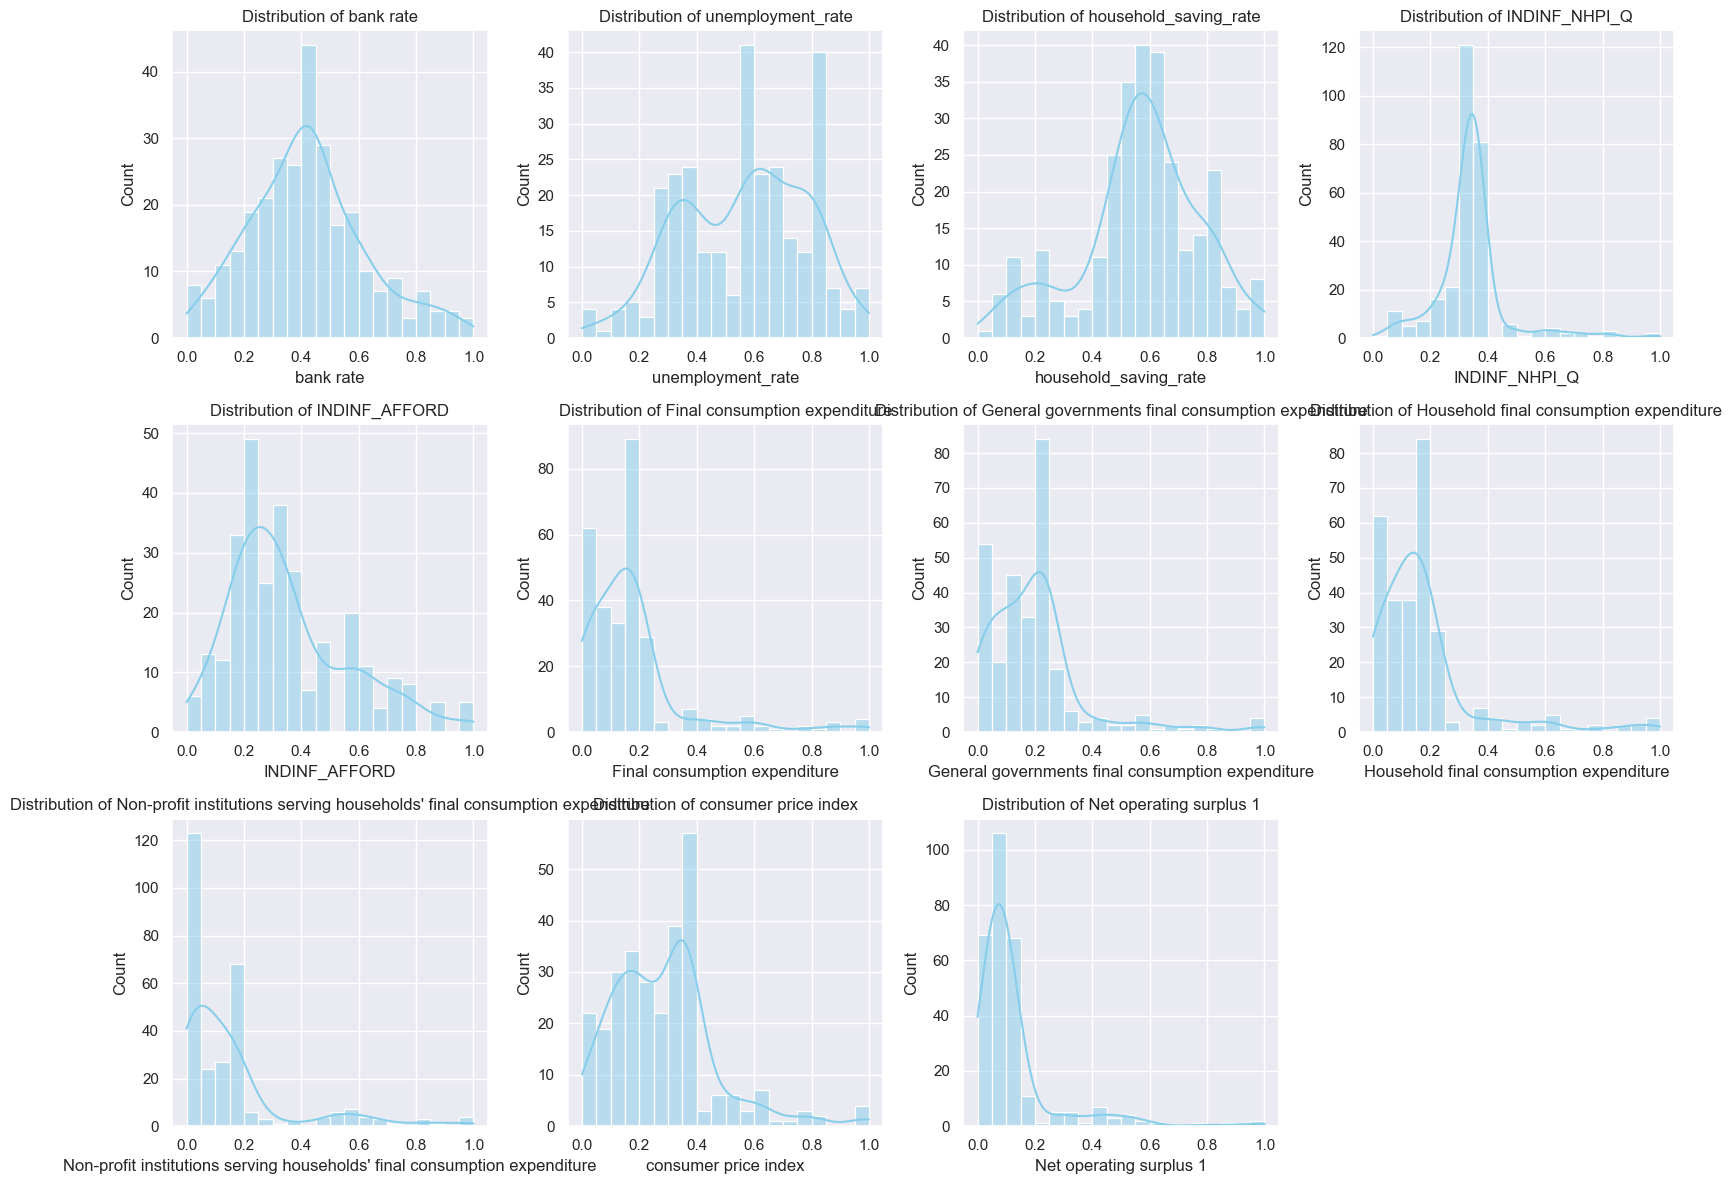

In [1177]:


features_to_visualize = ['bank rate', 'unemployment_rate', 'household_saving_rate', 'INDINF_NHPI_Q', 'INDINF_AFFORD',
                         'Final consumption expenditure', 'General governments final consumption expenditure',
                         'Household final consumption expenditure', 'Non-profit institutions serving households\' final consumption expenditure',
                         'consumer price index', 'Net operating surplus 1']

plt.figure(figsize=(16, 12))
for i, feature in enumerate(features_to_visualize, 1):
    plt.subplot(3, 4, i)
    sns.histplot(processed_df[feature], kde=True, bins=20, color='skyblue')
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()


In [1178]:
skewness = processed_df.skew()
skewed_features = processed_df.drop(columns=['year','month']).columns

skewed_features

Index(['bank rate', 'unemployment_rate', 'household_saving_rate',
       'INDINF_NHPI_Q', 'INDINF_AFFORD', 'Final consumption expenditure',
       'General governments final consumption expenditure',
       'Household final consumption expenditure',
       'Non-profit institutions serving households' final consumption expenditure',
       'consumer price index', 'Net operating surplus 1'],
      dtype='object')

In [1179]:
skewness

bank rate                                                                    0.454548
unemployment_rate                                                           -0.210016
household_saving_rate                                                       -0.462858
year                                                                         1.622170
month                                                                        0.047381
INDINF_NHPI_Q                                                                1.702313
INDINF_AFFORD                                                                0.992106
Final consumption expenditure                                                2.468481
General governments final consumption expenditure                            2.182647
Household final consumption expenditure                                      2.532874
Non-profit institutions serving households' final consumption expenditure    2.274035
consumer price index                                  

## Using Box-cox to hangle skewness in features

In [1196]:

for feature in skewed_features:
    processed_df[feature], _ = boxcox(processed_df[feature] + 1)


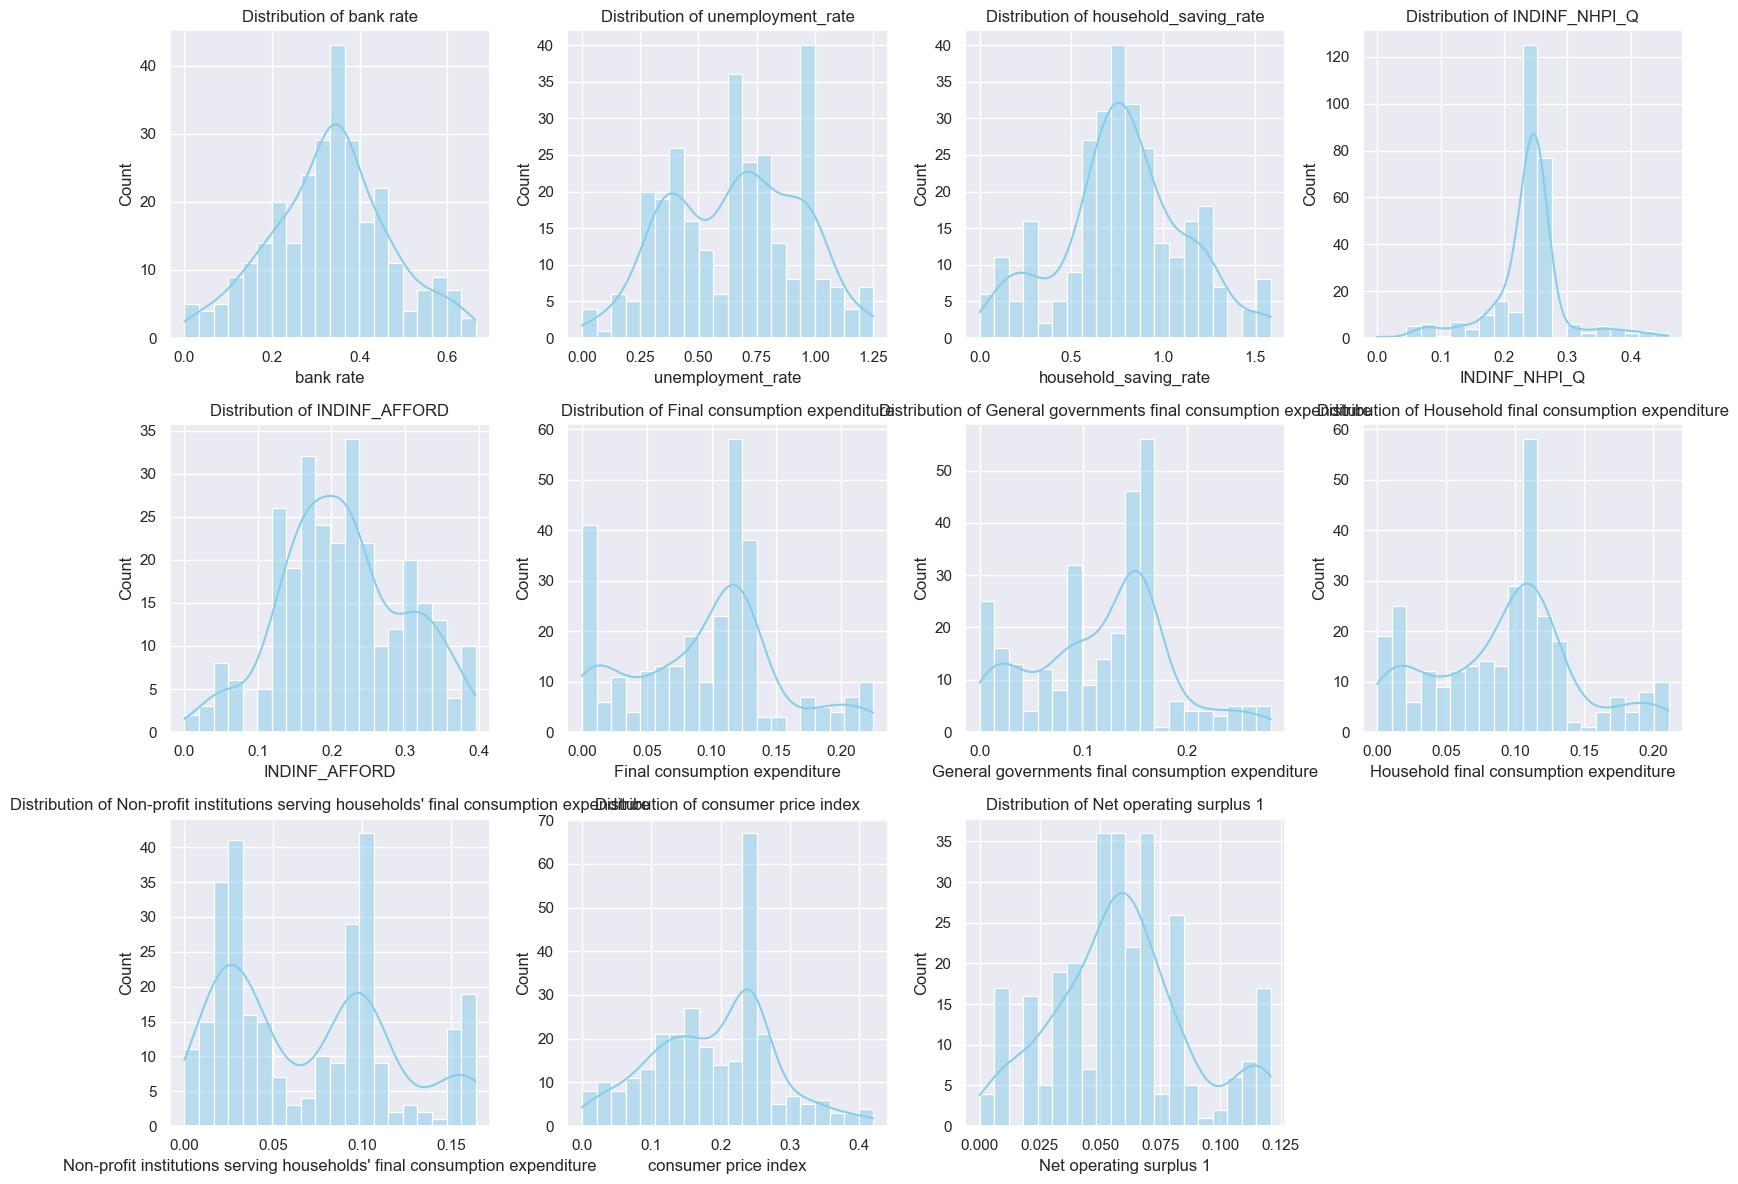

In [1197]:

features_to_visualize = ['bank rate', 'unemployment_rate', 'household_saving_rate', 'INDINF_NHPI_Q', 'INDINF_AFFORD',
                         'Final consumption expenditure', 'General governments final consumption expenditure',
                         'Household final consumption expenditure', 'Non-profit institutions serving households\' final consumption expenditure',
                         'consumer price index', 'Net operating surplus 1']

plt.figure(figsize=(16, 12))
for i, feature in enumerate(features_to_visualize, 1):
    plt.subplot(3, 4, i)
    sns.histplot(processed_df[feature], kde=True, bins=20, color='skyblue')
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()


# Visualizing Trend of all feature over the years

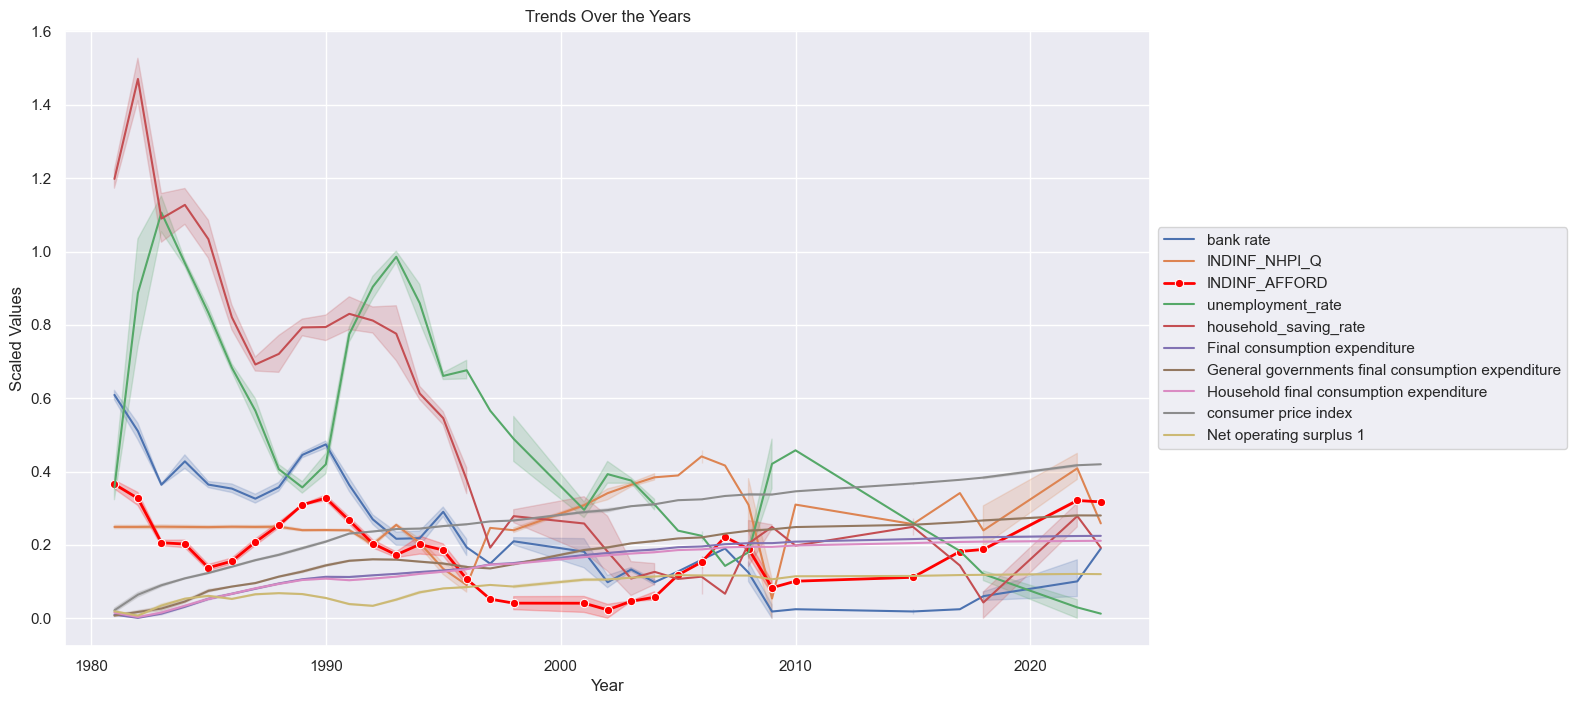

In [1198]:


sns.set(style="darkgrid")

plt.figure(figsize=(14, 8))

features_to_plot = ['bank rate', 'INDINF_NHPI_Q', 'INDINF_AFFORD', 
                    'unemployment_rate', 'household_saving_rate', 
                    'Final consumption expenditure', 
                    'General governments final consumption expenditure', 
                    'Household final consumption expenditure',
                   'consumer price index',
                   'Net operating surplus 1']

for feature in features_to_plot:
    if feature == 'INDINF_AFFORD':
        sns.lineplot(x='year', y=feature, data=processed_df, label=feature, marker='o', color='red', linewidth=2)
    else:
        sns.lineplot(x='year', y=feature, data=processed_df, label=feature)

plt.title('Trends Over the Years')
plt.xlabel('Year')
plt.ylabel('Scaled Values')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


# Correlation 

In [1183]:
correlation_matrix = processed_df[['bank rate', 'unemployment_rate', 'household_saving_rate', 'year',
       'month', 'INDINF_NHPI_Q', 'INDINF_AFFORD',
       'Final consumption expenditure',
       'General governments final consumption expenditure',
       'Household final consumption expenditure',
       'Non-profit institutions serving households\' final consumption expenditure',
       'consumer price index', 'Net operating surplus 1' ]].corr()

correlation_matrix


,bank rate,unemployment_rate,household_saving_rate,year,month,INDINF_NHPI_Q,INDINF_AFFORD,Final consumption expenditure,General governments final consumption expenditure,Household final consumption expenditure,Non-profit institutions serving households' final consumption expenditure,consumer price index,Net operating surplus 1
bank rate,1.000000,0.048320,0.812686,-0.811822,-0.008276,-0.030284,0.753219,-0.812299,-0.797521,-0.811406,-0.739149,-0.843413,-0.741438
unemployment_rate,0.048320,1.000000,0.463912,-0.448251,0.039318,-0.285428,-0.195963,-0.442576,-0.354433,-0.466882,-0.347482,-0.293645,-0.510711
household_saving_rate,0.812686,0.463912,1.000000,-0.840086,-0.022040,-0.049717,0.546534,-0.905521,-0.842882,-0.917794,-0.786648,-0.863590,-0.880167
year,-0.811822,-0.448251,-0.840086,1.000000,-0.020352,0.148018,-0.381050,0.931426,0.914952,0.930626,0.893550,0.929875,0.807822
month,-0.008276,0.039318,-0.022040,-0.020352,1.000000,-0.096424,-0.019010,0.005954,0.004809,0.005698,0.007062,0.017274,0.005547
INDINF_NHPI_Q,-0.030284,-0.285428,-0.049717,0.148018,-0.096424,1.000000,0.049313,0.056087,0.067328,0.054475,0.012540,0.016316,0.135977
INDINF_AFFORD,0.753219,-0.195963,0.546534,-0.381050,-0.019010,0.049313,1.000000,-0.423461,-0.376384,-0.431724,-0.370350,-0.442479,-0.559921
Final consumption expenditure,-0.812299,-0.442576,-0.905521,0.931426,0.005954,0.056087,-0.423461,1.000000,0.983406,0.998779,0.904319,0.980268,0.816674
General governments final consumption expenditure,-0.797521,-0.354433,-0.842882,0.914952,0.004809,0.067328,-0.376384,0.983406,1.000000,0.973743,0.883441,0.984666,0.741041
Household final consumption expenditure,-0.811406,-0.466882,-0.917794,0.930626,0.005698,0.054475,-0.431724,0.998779,0.973743,1.000000,0.898578,0.973419,0.836557


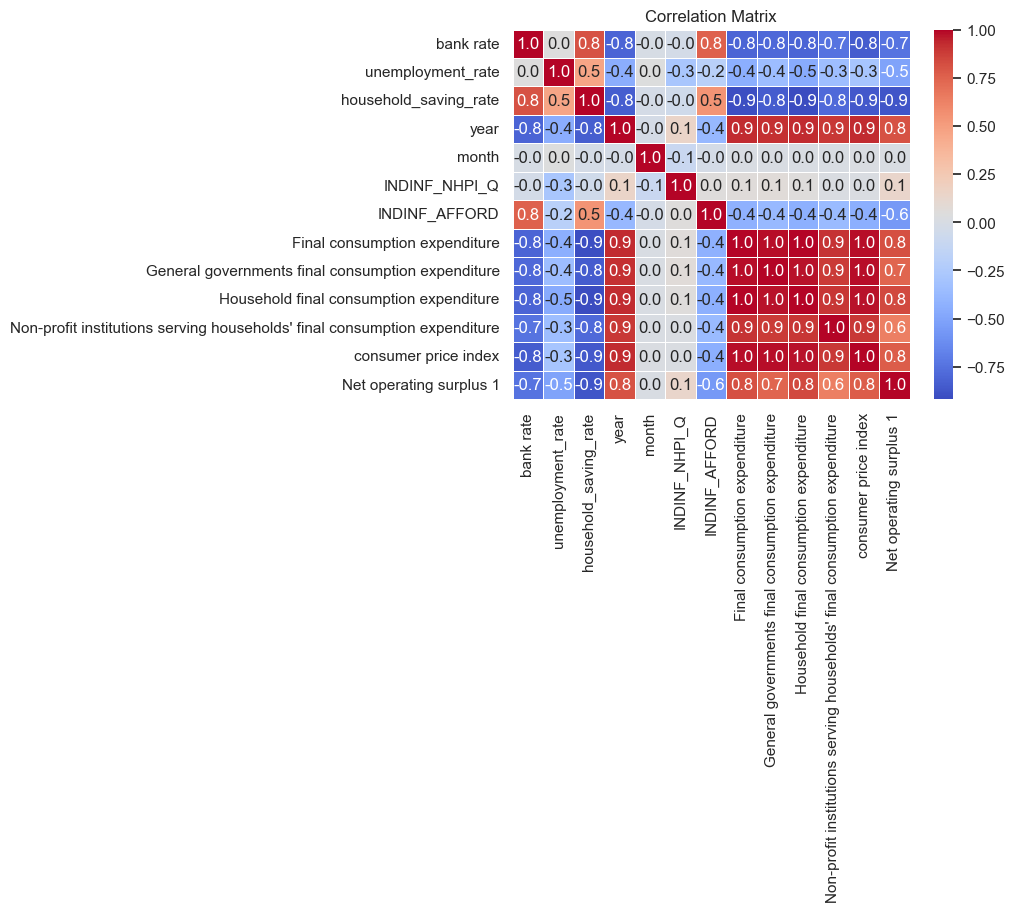

In [1184]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=.5)

plt.title('Correlation Matrix')

plt.show()

 There is some correlation found among all the features

# Determining importance of features keeping INDINF_AFFORD as target

In [1200]:

features = ['bank rate', 'unemployment_rate', 'household_saving_rate', 'year',
       'month', 'INDINF_NHPI_Q', 'INDINF_AFFORD',
       'Final consumption expenditure',
       'General governments final consumption expenditure',
       'Household final consumption expenditure',
       'Non-profit institutions serving households\' final consumption expenditure',
       'consumer price index', 'Net operating surplus 1']
target = 'INDINF_AFFORD'

X = processed_df[features]
y = processed_df[target]

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X, y)

feature_importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df


,Feature,Importance
6,INDINF_AFFORD,0.994862
0,bank rate,0.001634
4,month,0.001142
2,household_saving_rate,0.000557
10,Non-profit institutions serving households' fi...,0.000320
8,General governments final consumption expenditure,0.000310
7,Final consumption expenditure,0.000217
9,Household final consumption expenditure,0.000204
1,unemployment_rate,0.000188
11,consumer price index,0.000175


# Clustering Model training

## Elbow method to determing how many clusters to have in final clustering algorithm

E:\Conestoga\Foundation of ML\housing\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Conestoga\Foundation of ML\housing\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Conestoga\Foundation of ML\housing\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
E:\Conestoga\Foundation of ML\housing\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default 

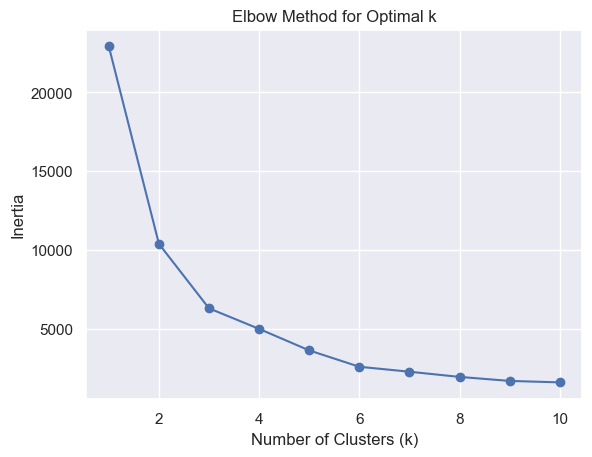

In [1201]:


features_for_clustering = ['bank rate', 'unemployment_rate', 'household_saving_rate', 'year',
       'month', 'INDINF_NHPI_Q', 'INDINF_AFFORD',
       'Final consumption expenditure',
       'General governments final consumption expenditure',
       'Household final consumption expenditure',
       'Non-profit institutions serving households\' final consumption expenditure',
       'consumer price index', 'Net operating surplus 1']

data_for_clustering = processed_df[features_for_clustering]

inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_for_clustering)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


# Training K Means Clustering algorithm

E:\Conestoga\Foundation of ML\housing\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


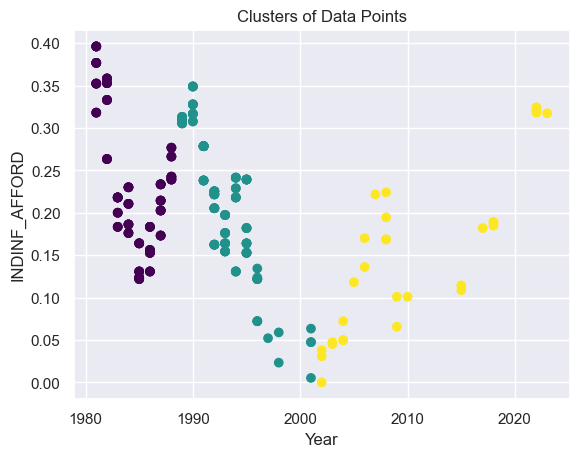

In [1202]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
processed_df['Cluster_Labels'] = kmeans.fit_predict(data_for_clustering)

plt.scatter(processed_df['year'], processed_df['INDINF_AFFORD'], c=processed_df['Cluster_Labels'], cmap='viridis')
plt.title('Clusters of Data Points')
plt.xlabel('Year')
plt.ylabel('INDINF_AFFORD')
plt.show()


In [1203]:

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_for_clustering)


E:\Conestoga\Foundation of ML\housing\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=42)

## Cluster cheracteristics suggesting the centroid of each cluster

In [1204]:
cluster_centers = kmeans.cluster_centers_
feature_names = processed_df.columns
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i + 1} Characteristics:")
    for feature, value in zip(feature_names, center):
        print(f"   {feature}: {value}")


Cluster 1 Characteristics:
   bank rate: 0.41603393069844735
   unemployment_rate: 0.7099868665863588
   household_saving_rate: 1.0133451002586027
   year: 1984.5116279069769
   month: 5.511627906976744
   INDINF_NHPI_Q: 0.2491343782633106
   INDINF_AFFORD: 0.2327890714885618
   Final consumption expenditure: 0.04436657672982204
   General governments final consumption expenditure: 0.05885815362360689
   Household final consumption expenditure: 0.04603917008024838
   Non-profit institutions serving households' final consumption expenditure: 0.02455746502525334
   consumer price index: 0.10973205649656553
   Net operating surplus 1: 0.04516423665748195
Cluster 2 Characteristics:
   bank rate: 0.30407748159208264
   unemployment_rate: 0.7025140660398248
   household_saving_rate: 0.686534450245877
   year: 1992.7751937984497
   month: 5.3023255813953485
   INDINF_NHPI_Q: 0.2092470568870166
   INDINF_AFFORD: 0.21486490574091713
   Final consumption expenditure: 0.1218939782705632
   Genera

# Inference on new data point

In [1205]:
new_data_point= pd.DataFrame({
    'bank rate': [-0.4],
    'unemployment_rate': [0.5],
    'household_saving_rate': [-0.2],
    'year': [2024],
    'month': [4],
    'INDINF_NHPI_Q': [0.4],
    'INDINF_AFFORD': [0.3],
    'Final consumption expenditure': [-0.1],
    'General governments final consumption expenditure': [0.6],
    'Household final consumption expenditure': [-0.3],
    'Non-profit institutions serving households\' final consumption expenditure': [0.8],
    'consumer price index': [-0.7],
    'Net operating surplus 1': [0.1]
})

new_data_point_label = kmeans.predict(new_data_point)

new_data_point['Cluster_Label'] = new_data_point_label +1


In [1206]:
new_data_point

,bank rate,unemployment_rate,household_saving_rate,year,month,INDINF_NHPI_Q,INDINF_AFFORD,Final consumption expenditure,General governments final consumption expenditure,Household final consumption expenditure,Non-profit institutions serving households' final consumption expenditure,consumer price index,Net operating surplus 1,Cluster_Label
0,-0.4,0.5,-0.2,2024,4,0.4,0.3,-0.1,0.6,-0.3,0.8,-0.7,0.1,3


In [1212]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
labels = processed_df['Cluster_Labels']


In [1213]:
silhouette_avg = silhouette_score(data_for_clustering, labels)
silhouette_avg

0.41461830475068984

In [1216]:
db_index = davies_bouldin_score(data_for_clustering, labels)
db_index

0.8437381306847508

In [1217]:
ch_index = calinski_harabasz_score(data_for_clustering, labels)
ch_index

376.0297725023789

Silhouette Score (0.415): This score indicates how similar an object is to its own cluster (cohesion) compared to other clusters (separation). A higher silhouette score suggests better-defined clusters.A score near +1 indicates that the sample is far away from the neighboring clusters. A score of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters. A score near -1 indicates that those samples might have been assigned to the wrong cluster.

Davies-Bouldin Index (0.844): This index measures the average similarity between each cluster and its most similar cluster. A lower value indicates better clustering. Lower values indicate better clustering. The minimum value is 0, which indicates perfectly separated clusters. Higher values suggest poorer clustering, and a higher value reflects a worse solution.

Calinski-Harabasz Index (376.03): This index measures the ratio of between-cluster variance to within-cluster variance. A higher value suggests better-defined clusters.

Overall, it looks like  clustering has produced reasonably good results, with a decent silhouette score,  low Davies-Bouldin Index, and a high Calinski-Harabasz Index.